In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from tqdm import tqdm

warnings.filterwarnings('ignore')

plt.rc('font', size=30)

In [2]:
train_data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv',dtype = 'float32')

In [3]:
X = train_data.drop('label', axis=1).values/255
y = train_data['label'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train = torch.reshape(torch.from_numpy(X_train),(X_train.shape[0],1,28,28))
y_train = torch.from_numpy(y_train).type(torch.LongTensor) 
X_valid = torch.reshape(torch.from_numpy(X_valid),(X_valid.shape[0],1,28,28))
y_valid = torch.from_numpy(y_valid).type(torch.LongTensor) 

train = TensorDataset(X_train,y_train)
valid = TensorDataset(X_valid,y_valid)


train_loader = DataLoader(train, batch_size=64, shuffle = True)
valid_loader = DataLoader(valid, batch_size=64, shuffle = False)

In [4]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss


In [5]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader):
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        
        x, y = x.to(device), y.to(device)
        
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [6]:
def plot_stats(valid_accuracy: []):

    plt.figure(figsize=(16, 8))

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [7]:
my_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5), 
    nn.LeakyReLU(0.05),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(32),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.LeakyReLU(0.05),
    nn.MaxPool2d(kernel_size=2),
    nn.BatchNorm2d(64),
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(4*4*64,392),
    nn.LeakyReLU(0.05),
    nn.Linear(392,196),
    nn.LeakyReLU(0.05),
    nn.Linear(196,49),
    nn.LeakyReLU(0.05),
    nn.Linear(49,10),
    nn.LogSoftmax(dim = 1))


# optimizer = torch.optim.Adam(my_model.parameters(), lr=0.1)
optimizer = torch.optim.SGD(my_model.parameters(), lr=0.1, momentum=0.9)

loss_fn = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.01, max_lr=0.1)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
my_model = my_model.to(device)

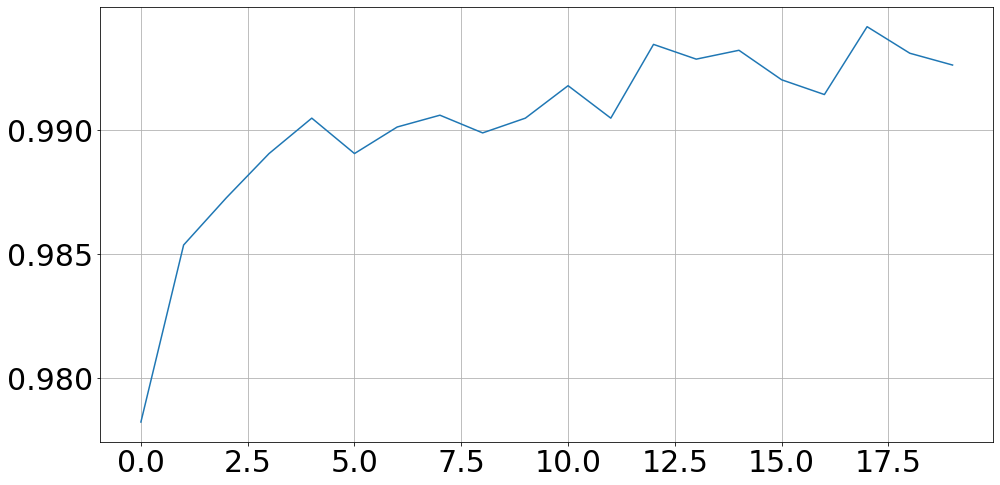

In [10]:
num_epochs = 20

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

for epoch in range(num_epochs):
    train_loss = train(my_model)

    valid_loss, valid_accuracy = evaluate(my_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(valid_accuracy_history) 
    
    scheduler.step()

In [11]:
test_data = pd.read_csv('/kaggle/input/digit-recognizer/test.csv',dtype = 'float32')

In [12]:
X_test = torch.reshape(torch.from_numpy(test_data.values/255),(test_data.shape[0],1,28,28)).cuda()

In [13]:
predictions = my_model(X_test)

preds = []
for i in range(predictions.size()[0]):
    preds.append(torch.argmax(predictions[i]).item())

In [14]:
answer = pd.DataFrame({'ImageId' : [i for i in range(28000)],
                                 'Label' : preds}).set_index('ImageId')

In [15]:
answer = answer.reset_index()
answer['ImageId'] = answer['ImageId'] + 1
answer = answer.set_index('ImageId')

# answer.to_csv('mnist.csv')